In [10]:
import matplotlib.pyplot as plt
import json
import os
import math
from core.data_processor import DataLoader
from core.model import Model

In [2]:
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 显示结果图表函数

In [3]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='正确值')
    plt.plot(predicted_data, label='预测值')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='正确值')
    # 填充预测列表，将其在图表中移动到正确的开始位置
    for i, data in enumerate(predicted_data):
        padding = [None for _ in range(i * prediction_len)]
        plt.plot(padding + data, label='预测值')
        plt.legend()
    plt.show()

# 加载实验一的配置文件

In [4]:
configs = json.load(open('test_2/config.json', 'r'))

# 数据加载器
### 创建一个 DataLoader的类 class 来加载数据，为数据加载层提供概括信息
* 传入文件名
* 确定用于训练与测试的数据百分比的分割变量
* 选择一列或多列数据来进行单维或多维分析的列变量

In [5]:
data = DataLoader(
    filename=os.path.join('data', configs['data']['filename']),
    split=configs['data']['train_test_split'],
    cols=configs['data']['columns']
)

## 1.划分训练集

In [6]:
x, y = data.get_train_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

## 2.划分测试集

In [7]:
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

## 3.模型构建
代码框架使用Model类和config.json文件来轻松构建模型的实例
构建网络的主函数是build_model（）函数，它接收解析的配置文件。

In [8]:
model = Model()
model.build_model(configs)

[Model] Model Compiled
Time taken: 0:00:01.176060


# 模型训练
我们创建了一个单独的运行模块，它将Model和DataLoader 抽象出来的信息组合起来并用于训练、输出和可视化。

### 一个重要的改变：
#### 不使用framework中的 model.train()方法，而使用创建的model.train_generator()  方法
#### 训练大型数据集时很容易耗尽内存，当model.train（）函数将整个数据集加载到内存中，
#### 然后对内存中的每个窗口标准化时，容易导致内存溢出。
~~~
~~~
#### 使用了Keras的fit_generator（）函数，允许使用python生成器动态训练数据集来绘制数据，这意味着内存利用率将大大降低。

In [12]:
# 记忆外生成训练
steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
model.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    save_dir=configs['model']['save_dir'],
    steps_per_epoch=steps_per_epoch
)

[Model] Training Started
[Model] 2 epochs, 32 batch size, 116 batches per epoch
Epoch 1/2


C:\Users\Administrator\Desktop\lstm-neurons\core\model.py:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(


116/116 [==============================] - 31s 208ms/step - loss: 0.0357
Epoch 2/2
116/116 [==============================] - 23s 202ms/step - loss: 0.0165
[Model] Training Completed. Model saved as saved_models\28112021-174353-e2.h5
Time taken: 0:01:28.148865


# 预测数据

* 第一种将以逐点方式进行预测，即我们每次仅预测单个点，将此点绘制为预测，然后沿着下一个窗口进行预测,并再次使用完整的测试数据预测下一个点。
* 对完整的序列进行预测

In [13]:
predictions_multiseq = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
predictions_pointbypoint = model.predict_point_by_point(x_test)  

[Model] Predicting Sequences Multiple...
[Model] Predicting Sequences Full...
[Model] Predicting Point-by-Point...


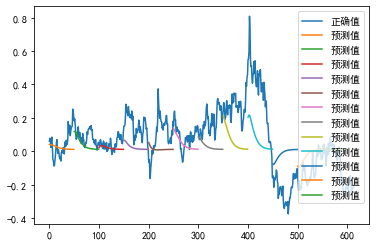

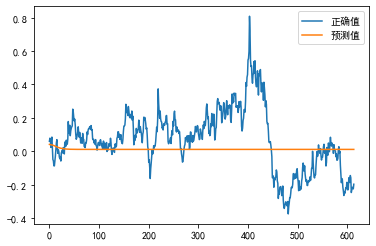

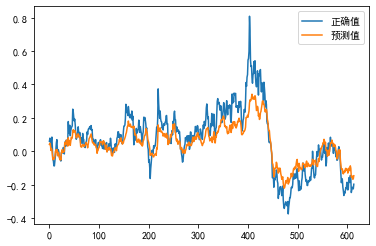

In [14]:
plot_results_multiple(predictions_multiseq, y_test, configs['data']['sequence_length'])
plot_results(predictions_fullseq, y_test)
plot_results(predictions_pointbypoint, y_test)